## 一、数据的加载和预处理

### 加载库

In [1]:
import numpy as np
import pandas as pd

### 读入数据

In [2]:
OnlRt=pd.read_csv('./Data/OnlineRetail.csv',
                  usecols=['CustomerID','InvoiceDate','UnitPrice','Quantity','Country'],
                  encoding = "ISO-8859-1",
                  parse_dates=['InvoiceDate'],
                  dtype={'CustomerID':np.str,'UnitPrice':np.float32,'Quantity':np.int32,'Country':np.str})

In [3]:
OnlRt.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### 数据清理

In [4]:
neg_id=OnlRt[(OnlRt['Quantity']<=0)|(OnlRt['UnitPrice']<=0)].loc[:,'CustomerID']
data0=OnlRt[(OnlRt['CustomerID'].notnull())&
            (~OnlRt['CustomerID'].isin(neg_id))&
            (OnlRt['Country']=='United Kingdom')].drop('Country',axis=1)

### 找出第一次交易时间

In [5]:
data1=data0.assign(amount=data0['UnitPrice'].multiply(data0['Quantity']))
first_time=data1['InvoiceDate'].sort_values(ascending=True).groupby(data1['CustomerID']).nth(0)\
.apply(lambda x:x.date()).reset_index().rename(columns={'InvoiceDate':'first_time'})
data2=pd.merge(data1,first_time,how='left',on=['CustomerID'])

### 添加新特征

In [6]:
dayth=(data2['InvoiceDate'].apply(lambda x: x.date())-data2['first_time']).apply(lambda x: x.days)

In [7]:
month=data2['InvoiceDate'].apply(lambda x: x.month)
weekday=data2['InvoiceDate'].apply(lambda x: x.weekday())
hour=data2['InvoiceDate'].apply(lambda x: x.hour)
minute=data2['InvoiceDate'].apply(lambda x: x.minute)
second=data2['InvoiceDate'].apply(lambda x: x.second)

In [8]:
hour_preci=(second/60+minute)/60+hour

### 整合特征

In [9]:
data3=data2.assign(dayth=dayth).assign(hour=hour_preci).\
assign(weekday=weekday).drop(['first_time','InvoiceDate'],axis=1).\
sort_values(by=['CustomerID','dayth','hour'])

### 分离特征数据和值数据

In [10]:
X=data3[data3['dayth']<28].set_index('CustomerID').drop('amount',axis=1).sort_index()

In [11]:
data180=data3[(data3['dayth']<180)&(data3['CustomerID'].isin(X.index))]
y=data180['amount'].groupby(data180['CustomerID']).sum().sort_index()

### 保存文件

In [12]:
X.to_csv('./Data/bookdata_X.csv',index=True,header=True)
y.to_csv('./Data/bookdata_y.csv',index=True,header=True)

## 二、输入数据的准备

### 加载库

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Conv1D, Dropout, LSTM, TimeDistributed, Bidirectional, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


### 读取文件

In [14]:
columns_picked=['CustomerID','Quantity', 'UnitPrice', 'dayth', 'hour', 'weekday']

y=pd.read_csv('bookdata_y.csv').rename(columns={'CustomerID':'id'}).set_index('id')['amount']
X=pd.read_csv('bookdata_X.csv',usecols=columns_picked
             ).rename(columns={'CustomerID':'id'}).set_index('id')
columns_picked.remove('CustomerID')

### 分离训练集和测试集

In [15]:
indices=y.index.tolist()
ind_train,ind_test=map(sorted,train_test_split(indices, test_size=0.25,
                                               random_state=42))

X_train=X.loc[ind_train,:]
y_train=y[ind_train]

X_test=X.loc[ind_test,:]
y_test=y[ind_test]

### 数据标准化

In [16]:
scaler=MinMaxScaler(feature_range=(-0.5,0.5))
X_train_scaled =pd.DataFrame(scaler.fit_transform(X_train),
                             columns=X_train.columns,
                             index=X_train.index)

In [17]:
y_train_log=y_train.apply(np.log)

/Applications/anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0, 10, 0, 250]

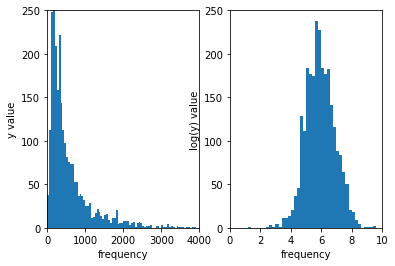

In [18]:
plt.figure();
plt.subplot(1,2,1)
y.hist(bins=np.arange(0,4000,50))
plt.xlabel('frequency')
plt.ylabel('y value')
plt.grid('off')
plt.axis([0,4000,0,250])
plt.subplot(1,2,2)
y.apply(np.log).hist(bins=np.arange(0,10,0.2))
plt.xlabel('frequency')
plt.ylabel('log(y) value')
plt.grid('off')
plt.axis([0,10,0,250])

### 数据形状的处理

In [19]:
week_train=X_train['dayth'].apply(lambda x: int(x/7)).rename('week')

In [20]:
inner_length=32
outer_length=4
feature_len=len(columns_picked)

In [21]:
def cut_pad(x,maxl):
    head=np.array(x)[0:maxl]
    head_padding=head if len(head)==maxl else np.pad(head,(0,maxl-len(head)),mode='constant')
    return head_padding

In [22]:
def feature_array(df, col_n, week,len_outer,len_inner):
    col=df[[col_n]].assign(week=week).reset_index()

    ids=col['id'].drop_duplicates().values.tolist()
    weeks=np.arange(0,len_outer).tolist()

    id_week=pd.DataFrame([(id,week) for id in ids for week in weeks]).rename(columns={0:'id',
                                                                                      1:'week'}).sort_values(by=['id','week'])

    arr_base=pd.merge(id_week, col, how='left',on=['id','week']).fillna(0)

    arr_frame=arr_base[col_n].groupby([arr_base['id'],arr_base['week']]).\
    apply(lambda x: cut_pad(x,len_inner)).reset_index().drop('week',axis=1).set_index('id')[col_n]

    userarray=arr_frame.groupby(arr_frame.index).apply(np.vstack).\
    apply(lambda x: x.reshape([1,x.shape[0],x.shape[1]])).sort_index()
    userarray_var=np.vstack(userarray.values.tolist())

    return userarray.index.tolist(),userarray_var

In [23]:
def make_data_array(df,columns,week,len_outer,len_inner):
    ids_num = len(set(df.index))

    df_ready = np.zeros([ids_num,len_outer,len_inner,len(columns)])
    for i,item in enumerate(columns):
        the_ind, df_ready[:,:,:,i] = feature_array(df,item,week,len_outer,len_inner)

    return the_ind,df_ready

In [24]:
X_train_ind,X_train_data=make_data_array(X_train_scaled,columns_picked,week_train,outer_length,inner_length)

In [25]:
X_test_scaled =pd.DataFrame(scaler.transform(X_test),
                            columns=X_test.columns,
                            index=X_test.index)

y_test_log=y_test.apply(np.log)

week_test=X_test['dayth'].apply(lambda x: int(x/7)).rename('week')

X_test_ind,X_test_data=make_data_array(X_test_scaled,columns_picked,week_test,outer_length,inner_length)

## 三、模型搭建和训练

### 模型搭建

In [26]:
def build_model(len_outer,len_inner,len_fea):
    filters = [64,32]
    kernel_size = [2,2]
    dropout_rate=[0.1,0]

    inner_input = Input(shape=(len_inner,len_fea), dtype='float32')
    cnn1d=inner_input
    for i in range(len(filters)):
        cnn1d = Conv1D(filters=filters[i],
                       kernel_size=kernel_size[i],
                       padding='valid',
                       activation='relu',
                       strides=1)(cnn1d)
        cnn1d = Dropout(dropout_rate[i])(cnn1d)
    lstm = LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(cnn1d)
    inner_output = LSTM(16, return_sequences=False)(lstm)
    inner_model = Model(inputs=inner_input, outputs=inner_output)

    outer_input = Input(shape=(len_outer, len_inner,len_fea), dtype='float32')
    innered = TimeDistributed(inner_model)(outer_input)
    outered=Bidirectional(LSTM(16, return_sequences=False))(innered)
    outered = Dense(8, activation='relu')(outered)
    outer_output = Dense(1)(outered)

    model = Model(inputs=outer_input, outputs=outer_output)
    model.compile(loss='mape', optimizer='adam')

    return model,inner_model

In [27]:
LTV_model, LTV_inner_model = build_model(outer_length,inner_length,feature_len)

In [28]:
LTV_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 32, 5)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 16)             16288     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 20,785
Trainable params: 20,785
Non-trainable params: 0
_________________________________________________________________


In [29]:
LTV_inner_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 64)            704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 32)            4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
Total para

### 模型训练

In [30]:
cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = LTV_model.fit(x=X_train_data,
                        y=y_train_log,
                        validation_data=(X_test_data, y_test_log),
                        epochs=200,
                        batch_size=128,
                        callbacks=[cb],
                        verbose=2)

LTV_model.save('LTV_model.h5')

Train on 1900 samples, validate on 634 samples
Epoch 1/200
 - 16s - loss: 97.9124 - val_loss: 93.0421
Epoch 2/200
 - 11s - loss: 77.5284 - val_loss: 55.3135
Epoch 3/200
 - 12s - loss: 36.1316 - val_loss: 15.1874
Epoch 4/200
 - 11s - loss: 14.6390 - val_loss: 13.1785
Epoch 5/200
 - 11s - loss: 13.7543 - val_loss: 12.8265
Epoch 6/200
 - 11s - loss: 13.3501 - val_loss: 12.2620
Epoch 7/200
 - 11s - loss: 13.3779 - val_loss: 12.3732
Epoch 8/200
 - 11s - loss: 13.3532 - val_loss: 12.2312
Epoch 9/200
 - 11s - loss: 13.3482 - val_loss: 12.3343
Epoch 10/200
 - 11s - loss: 13.3244 - val_loss: 12.2819
Epoch 11/200
 - 11s - loss: 13.3099 - val_loss: 12.2126
Epoch 12/200
 - 11s - loss: 13.2894 - val_loss: 12.3198
Epoch 13/200
 - 11s - loss: 13.2878 - val_loss: 12.2164
Epoch 14/200
 - 11s - loss: 13.2685 - val_loss: 12.2337
Epoch 15/200
 - 11s - loss: 13.2725 - val_loss: 12.2178
Epoch 16/200
 - 11s - loss: 13.2520 - val_loss: 12.1709
Epoch 17/200
 - 11s - loss: 13.2483 - val_loss: 12.3258
Epoch 18/2

### 模型分析

[0, 200, 0, 100]

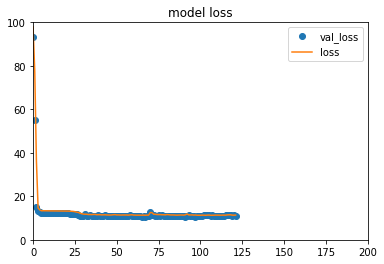

In [31]:
plt.figure()
plt.plot(history.history['val_loss'],'o',label='val_loss')
plt.plot(history.history['loss'],'-',label='loss')
plt.title('model loss')
plt.legend()
plt.axis([0,200,0,100])